In [4]:
"""
Expects a csv file with image id, maxlat, maxlon, minlat, minlon of each satellite image
Expects json files as a folder with the polygons parsed from the shapefile
Expects images for overlaying masks on images

"""

import json
import numpy as np
import pandas as pd
import sys
import os
import cv2
import imageio
import csv
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import defaultdict 

# Helper functions

In [18]:
def create_empty_overlays(grid, orig_images_dir, prefix='', suffix='', img_type='.tif', n=100):
    """
    Initiate empty masks and original images into the output folder based on the
    
    Args:
        grid (list): information from csv, so the empty masks to be overwritten later
    """
    count = 0
    for index in grid.keys():
        image_id = grid[index]['image_id']
        #image_id = str(grid[index]['image_id']).zfill(4)
        if count > n:
            break
            
        im_name = os.path.join(orig_images_dir, str(prefix) + str(image_id) + str(suffix) + img_type)
        orig_image = cv2.imread(im_name)
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
        cv2.imwrite(overlay_path, orig_image)
        count += 1

def create_dict_parcels(shp_dict):
    """
    Put the found fields from the parsed json into dict of image ids
    Args:
        shp_dict (dict): json dict containing the polygon fields

    Returns:
        dict: contains image id to polygons
    """
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['image_id']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

def scale_coords(shape_size, geom, grid, index):
    """
    scales the polygons lat/lon to pixel 
    Args:
        shape_size (tuple): size of the image to be scaled to
        geom (polygon): field polygon
        grid (list): values of min/max lat/lon for each image id
        index (int): Index of each image id in grid

    Returns:
        list: scaled coordinates
    """
    w, h = shape_size
    min_lat, min_lon, max_lat, max_lon = grid[index]['min_lat'], grid[index]['min_lon'], \
        grid[index]['max_lat'], grid[index]['max_lon']
    x = geom[:,0]
    y = geom[:,1]
    scale_lon = w/(max_lon - min_lon)
    scale_lat = h/(max_lat-min_lat)
    scaled_x = (x - min_lon) * scale_lon # lon-> x, lat->y
    scaled_y = h - ((y - min_lat) * scale_lat)
    if any(val > w for val in scaled_x) or any(val > h for val in scaled_y) \
        or any(val < 0 for val in scaled_x) or any (val < 0 for val in scaled_y):
        return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)
    return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)

# Setup

In [19]:
def get_grid(df):
    """
    Read the CSV file containing minmax lat/lon and stores it to a 2D list

    Args:
        df: pandas dataframe of bounding boxes

    Returns:
        list: contains the imag_id and lat/long information
    """
    grid = dict()
    keys = ['max_lat', 'max_lon', 'min_lat', 'min_lon']

    for index, row in df.iterrows():
        if index not in grid:
            grid[index] = dict()
        grid[index]['image_id'] = row['image_id']
        grid[index]['max_lat'] = float(row['max_lat'])
        grid[index]['max_lon'] = float(row['max_lon'])
        grid[index]['min_lat'] = float(row['min_lat'])
        grid[index]['min_lon'] = float(row['min_lon'])
        
    return grid

### Planet images

In [83]:
# ======================== USER SETUP ======================== #
# Directories to read the necessary files from
# base_dir = '../data/planet/india/random'
# base_dir = '../data/planet/india/geowiki/'
# base_dir = '../data/planet/india/GeneralBlockchain/'
# label_folder = 'extent_labels/'
# overlay_folder = 'overlays/'

# csv_file = os.path.join(base_dir, 'bbox1000.csv')
# json_file = '../data/planet/india/json_polys/bbox1000_labeled1600.json'
# csv_file = os.path.join(base_dir, 'geowiki_maharashtra.csv')
# json_file = '../data/planet/india/geowiki/json_polys/geowiki_labeled259.json'
# orig_images_dir = '../data/planet/india/geowiki'

# samples
# csv_file = os.path.join(base_dir, 'bbox_india_GB_v1.csv')
# json_file = os.path.join(base_dir, 'bbox_images26405_samples.json')
# base_dir = '../data/planet/india/GeneralBlockchain/'
# label_folder = 'extent_labels/'
# overlay_folder = 'overlays/'

# large full images
base_dir = '../data/planet/india/GeneralBlockchain/'
csv_file = os.path.join(base_dir, 'bbox_india_GB_download_v2.csv')
json_file = os.path.join(base_dir, 'json_polys/bbox_images10027.json')
label_folder = 'extent_labels_large/'
overlay_folder = 'overlays_large/'

orig_images_dir = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged', '2020_10')

year_month = '_2020_10'
thickness = 2
# ============================================================ #

df = pd.read_csv(csv_file)
df['image_id'] = df['image_id'].astype(str).str.zfill(4)
df = df.sort_values('image_id').reset_index(drop=True)
grid = get_grid(df)

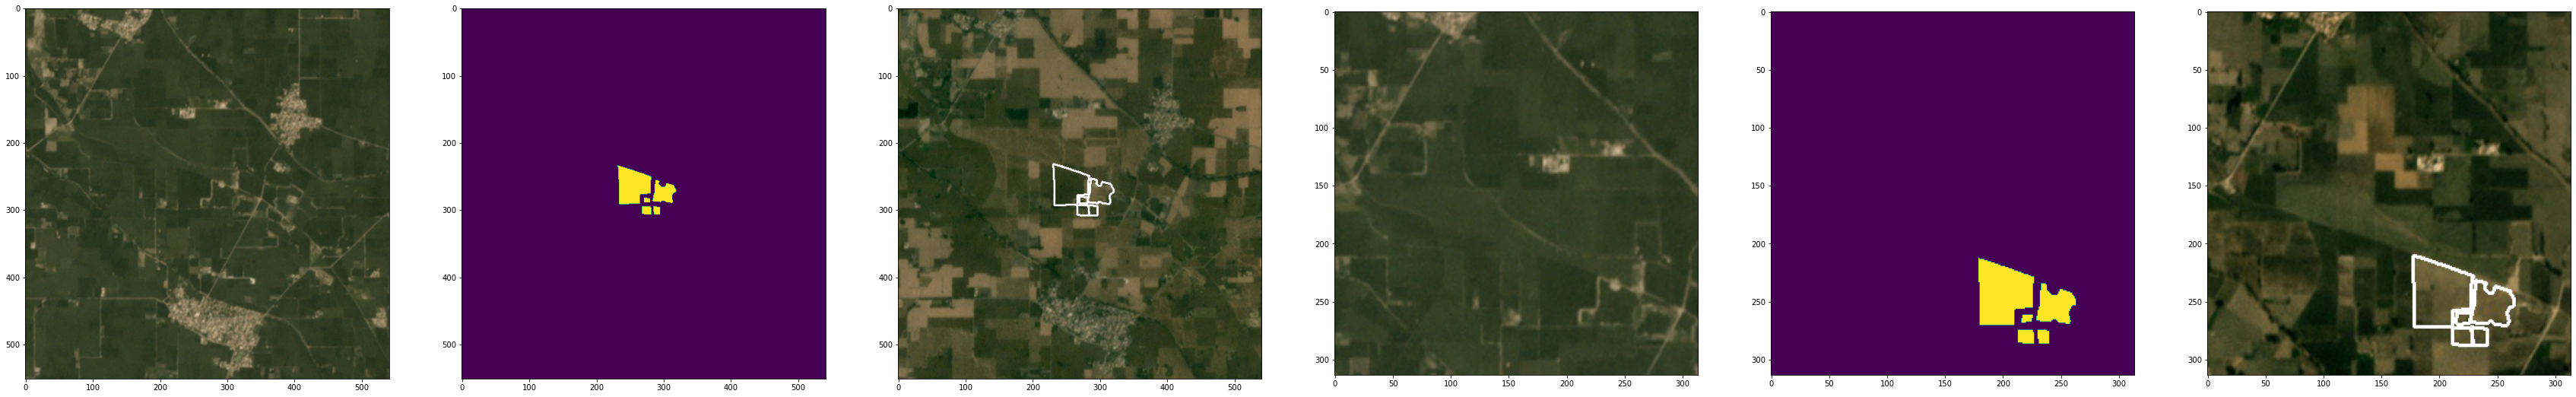

In [89]:
image_id = '0005'
img = imageio.imread('../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/2020_09/{}_2020_09.tif'.format(image_id))
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_large/{}.png'.format(image_id))
overlay = imageio.imread('../data/planet/india/GeneralBlockchain/overlays_large/{}.jpeg'.format(image_id))

img2 = imageio.imread('../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_samples/2020_09/{}a_2020_09.tif'.format(image_id))
label2 = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_sample/{}a.png'.format(image_id))
overlay2 = imageio.imread('../data/planet/india/GeneralBlockchain/overlays_samples/{}a.jpeg'.format(image_id))

fig, ax = plt.subplots(1, 6, figsize=(60, 10))
ax[0].imshow(img)
ax[1].imshow(label)
ax[2].imshow(overlay)
ax[3].imshow(img2)
ax[4].imshow(label2)
ax[5].imshow(overlay2)
plt.show()

In [37]:
df
# (73.09554299999999, 26.309582000000013, 0.0)
# (73.11609622600105, 26.291425659741286, 0.0) # not exactly the same, but only ~1-2m off?

image_id    min_lon    min_lat    max_lon    max_lat
0        0000  73.095543  26.291410  73.116079  26.309582
1        0115  72.935907  26.008257  72.956854  26.025434
2        0501  82.110905  22.716429  82.134103  22.737284
3        0781  85.232995  22.557453  85.256743  22.579392
4        0794  82.609664  25.755859  82.633272  25.777156
...       ...        ...        ...        ...        ...
1997     1995  72.808879  24.498566  72.832193  24.519663
1998     1996  79.143810  20.482731  79.164658  20.503792
1999     1997  75.276057  30.098849  75.299550  30.119647
2000     2000  75.750718  30.949851  75.774914  30.971456
2001     2002  91.473469  26.615159  91.497431  26.636358

[2002 rows x 5 columns]

### Large Airbus images

In [20]:
# ======================== USER SETUP ======================== #
# Directories to read the necessary files from
base_dir = '../data/general_blockchain/'
label_folder = 'extent_labels/large/3x_downsample_v2/'
overlay_folder = 'overlays/'

csv_file = os.path.join(base_dir, 'bbox_india_GB_large_Airbus.csv')
json_file = os.path.join(base_dir, 'json_polys/bbox_Airbus_large9975.json')
orig_images_dir = os.path.join(base_dir, 'airbus_false_color/large/3x_downsample/')

# year_month = '_2019_12'
thickness = 1 # 6
# ============================================================ #

df = pd.read_csv(csv_file)
df['image_id'] = df['image_id'].astype(str).str.zfill(4)
grid = get_grid(df)

# Run label generation

In [8]:
# create output directory if not exist
if os.path.exists(os.path.join(base_dir, label_folder)) == False:
    os.makedirs(os.path.join(base_dir, label_folder))
if os.path.exists(os.path.join(base_dir, overlay_folder)) == False:
    os.makedirs(os.path.join(base_dir, overlay_folder))

## General Blockchain images

In [84]:
# temp - only downloaded "c" images
# new_grid = {}
# for key in grid:
#     if 'b' in grid[key]['image_id']:
#         new_grid[key] = grid[key]
new_grid = grid

### Planet images

In [32]:
n_overlays = 20
create_empty_overlays(new_grid, orig_images_dir, suffix='_2020_10', n=n_overlays)

In [41]:
parcels_dict[115]

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[72.94399496213173, 26.019300583537273],
     [72.94399496213173, 26.019340701099495],
     [72.94400838904411, 26.019340664370525],
     [72.94402172584223, 26.01934070414339],
     [72.94402172584223, 26.019354076664165],
     [72.9440663320197, 26.019354052591996],
     [72.94408417448835, 26.019354025477977],
     [72.94408417448834, 26.01937194291093],
     [72.94412878065411, 26.01937191881809],
     [72.94414211744548, 26.01937187117678],
     [72.94414211744548, 26.01938524370204],
     [72.9441733868115, 26.01938526723519],
     [72.94418672360037, 26.01938530699162],
     [72.94418672360037, 26.019398679518453],
     [72.94423132974688, 26.019398655391242],
     [72.94424917220314, 26.01939862825519],
     [72.94424917220314, 26.0194120007845],
     [72.94429377833795, 26.019412064038015],
     [72.94430711512005, 26.019412016379995],
     [72.94430711512005, 26.019425388911543],
     [72.9443517212439

In [47]:
overlay_path

'../data/planet/india/GeneralBlockchain/overlays_large/2001.jpeg'

In [85]:
count_parcels = defaultdict(int)
num_fields_parsed = 0

# read multiple json files
print('Read json', json_file)

# open the saved json file for the found parcels in the images 
with open(json_file) as f:
    shp_dict = json.load(f)

# create dictionary of polygons in each image for fast indexing
parcels_dict = create_dict_parcels(shp_dict)

# find the polygons of each image and plot them
for index in new_grid.keys():
    
    # TODO: REMOVE THIS
    if index > 20:
        break

    image_id = int(new_grid[index]['image_id'])
    polys = []
    if image_id in parcels_dict:
#         print(image_id)
        img = imageio.imread(os.path.join(orig_images_dir, str(image_id).zfill(4) + '{}.tif'.format(year_month)))
        shape_size = (img.shape[0], img.shape[1])
        extent_path = os.path.join(base_dir, label_folder, str(image_id).zfill(4) + '.png')
        extent_label = np.zeros(shape_size)

        for sh_index, sh in enumerate(parcels_dict[image_id]):
            count_parcels[image_id] += 1 
            for coord_idx in range(len(sh['geometry']['coordinates'])):
                geom = np.array(sh['geometry']['coordinates'][coord_idx])
                try:
                    geom_fixed = scale_coords(shape_size, geom, new_grid, index)
                except:
                    print("Exception in image {}".format(image_id))
                    print(geom)
                pts = geom_fixed.astype(int)
                cv2.fillPoly(extent_label, [pts], color=1)
                polys.append(pts)

        # Save the extent label
#         cv2.polylines(extent_label, polys, True, color=0, thickness=thickness)
#         cv2.imwrite(extent_path, extent_label)

        # Saves the overlay file
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id).zfill(4) + '.jpeg')
        if os.path.exists(overlay_path):
            orig_image = cv2.imread(os.path.join(orig_images_dir, str(image_id).zfill(4) + year_month + '.tif'))
            cv2.imwrite(overlay_path, orig_image)
            orig_image = cv2.imread(overlay_path)
            cv2.polylines(orig_image, polys, True, color=(255,255,255), thickness=thickness)
            cv2.imwrite(overlay_path, orig_image)
            print('saved image ', image_id)

Read json ../data/planet/india/GeneralBlockchain/json_polys/bbox_images10027.json
saved image  0
saved image  1
saved image  2
saved image  3
saved image  4
saved image  5
saved image  6
saved image  7
saved image  8
saved image  9
saved image  10
saved image  11
saved image  12
saved image  13
saved image  14
saved image  15
saved image  16
saved image  17
saved image  18
saved image  19
saved image  20


### Large Airbus images

In [21]:
n_overlays = 10
prefix = 'airbus_geowiki_C'
suffix = ''
img_type = '.png'
# create_empty_overlays(new_grid, orig_images_dir, prefix='airbus_geowiki_C', suffix='', img_type='.png', n=n_overlays)

count = 0
for index in grid.keys():
    image_id = grid[index]['image_id']
    if count > n_overlays:
        break

    im_name = os.path.join(orig_images_dir, str(prefix) + str(image_id) + str(suffix) + img_type)
    if os.path.exists(im_name):
        orig_image = cv2.imread(im_name)
        overlay_path = os.path.join(base_dir, overlay_folder, str(prefix) + str(image_id) + str(suffix) + '.jpeg')
        cv2.imwrite(overlay_path, orig_image)
        count += 1

In [21]:
count_parcels = defaultdict(int)
num_fields_parsed = 0
prefix = 'airbus_geowiki_C'

# read multiple json files
print('Read json', json_file)

# open the saved json file for the found parcels in the images 
with open(json_file) as f:
    shp_dict = json.load(f)

# create dictionary of polygons in each image for fast indexing
parcels_dict = create_dict_parcels(shp_dict)

# find the polygons of each image and plot them
for index in new_grid.keys():

    image_id = new_grid[index]['image_id']
    polys = []
    if int(image_id) in parcels_dict:
        img_path = os.path.join(orig_images_dir, prefix + str(image_id) + '.png')
        
        if os.path.exists(img_path):
            img = imageio.imread(img_path)
            shape_size = (img.shape[0], img.shape[1])
            extent_path = os.path.join(base_dir, label_folder, prefix + str(image_id) + '.png')
            extent_label = np.zeros(shape_size)
            
            for sh_index, sh in enumerate(parcels_dict[int(image_id)]):
                count_parcels[image_id] += 1 
                for coord_idx in range(len(sh['geometry']['coordinates'])):
                    geom = np.array(sh['geometry']['coordinates'][coord_idx])
                    try:
                        geom_fixed = scale_coords(shape_size, geom, new_grid, index)
                    except:
                        print("Exception in image {}".format(image_id))
                        print(geom)
                    pts = geom_fixed.astype(int)
                    cv2.fillPoly(extent_label, [pts], color=1)
                    polys.append(pts)

            # Save the extent label
            cv2.polylines(extent_label, polys, True, color=0, thickness=thickness)
            cv2.imwrite(extent_path, extent_label)

            # Saves the overlay file
#             overlay_path = os.path.join(base_dir, overlay_folder, prefix + str(image_id) + '.jpeg')
#             if os.path.exists(overlay_path):
#                 orig_image = cv2.imread(os.path.join(orig_images_dir, prefix + str(image_id) + '.png'))
#                 cv2.imwrite(overlay_path, orig_image)
#                 orig_image = cv2.imread(overlay_path)
#                 cv2.polylines(orig_image, polys, True, color=(255,255,255), thickness=thickness)
#                 cv2.imwrite(overlay_path, orig_image)
#                 print('saved image ', image_id)

Read json ../data/general_blockchain/json_polys/bbox_Airbus_large9975.json


In [66]:
label_names = os.listdir('../data/general_blockchain/airbus_labels/large/erosion1px/')
for label_name in label_names:
    if not os.path.exists(os.path.join('../data/general_blockchain/airbus_false_color/large/3x_downsample/', label_name)):
        print(label_name)
        
img_names = os.listdir('../data/general_blockchain/airbus_false_color/large/3x_downsample/')
for img_name in img_names:
    if not os.path.exists(os.path.join('../data/general_blockchain/airbus_labels/large/erosion1px/', img_name)):
        print(img_name)

airbus_geowiki_C0788.png


### Verify labels

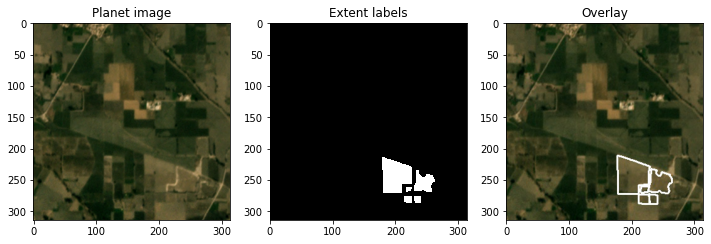

In [5]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '0005a'
year_month = '_2019_12'

mask = imageio.imread(
    '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_samples/2019_12/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/GeneralBlockchain/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

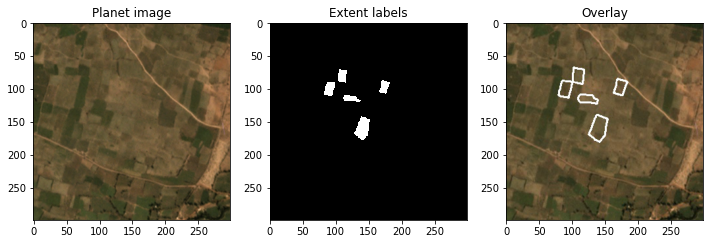

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '0001a'

mask = imageio.imread(
    '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/2019_12/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/GeneralBlockchain/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

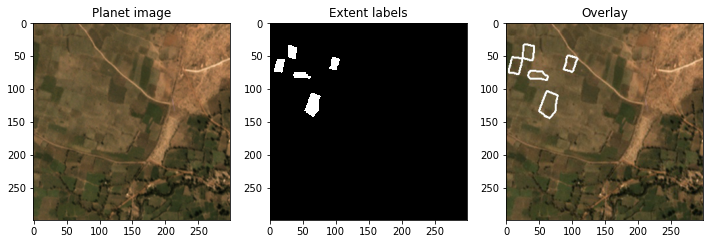

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '0001b'

mask = imageio.imread(
    '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/2019_12/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/GeneralBlockchain/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

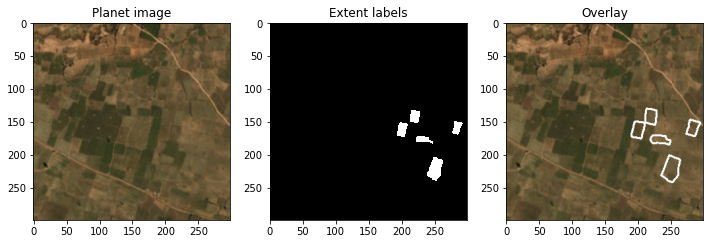

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '0001c'

mask = imageio.imread(
    '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/2019_12/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/GeneralBlockchain/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

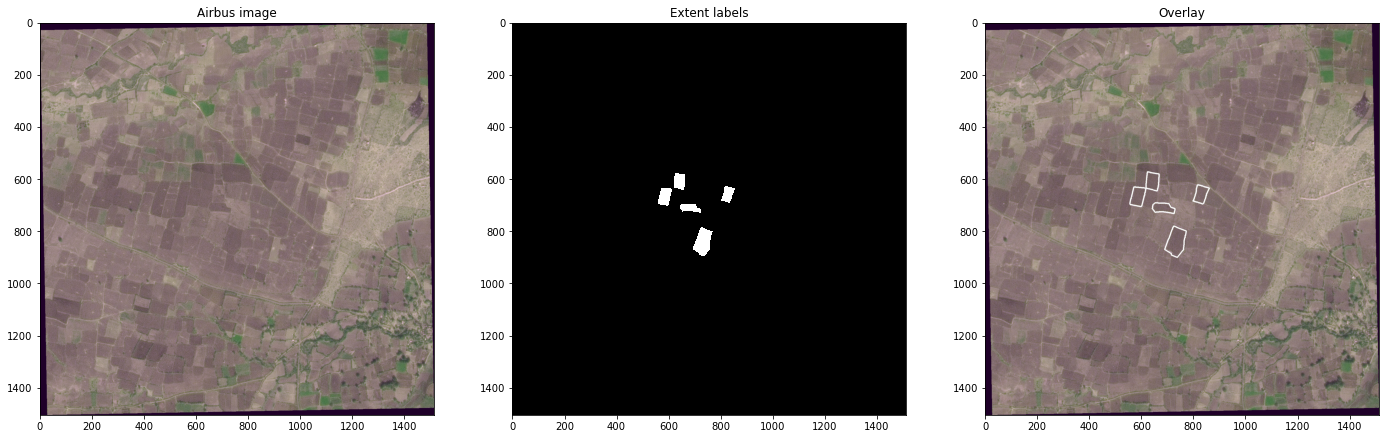

In [5]:
fig, ax = plt.subplots(1,3, figsize=(24,8))

image_id = '0001'

mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/original/{}.png'.format(
    'airbus_geowiki_C' + image_id))
ax[0].imshow(mask)
ax[0].set_title('Airbus image')

extent = imageio.imread('../data/general_blockchain/extent_labels/large/original_thickness3/{}.png'.format('airbus_geowiki_C' + image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/general_blockchain/overlays/{}.jpeg'.format('airbus_geowiki_C' + image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

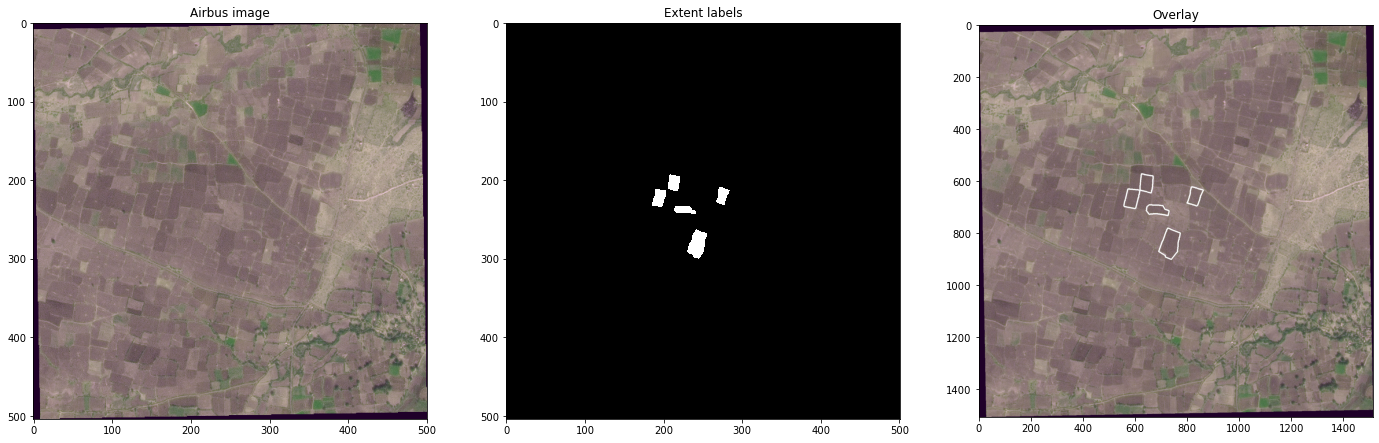

In [6]:
fig, ax = plt.subplots(1,3, figsize=(24,8))

image_id = '0001'

mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
ax[0].imshow(mask)
ax[0].set_title('Airbus image')

extent = imageio.imread('../data/general_blockchain/extent_labels/large/3x_downsample/{}.png'.format('airbus_geowiki_C' + image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/general_blockchain/overlays/{}.jpeg'.format('airbus_geowiki_C' + image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

In [7]:
print(mask.shape)
print(extent.shape)

(504, 501, 3)
(504, 501)


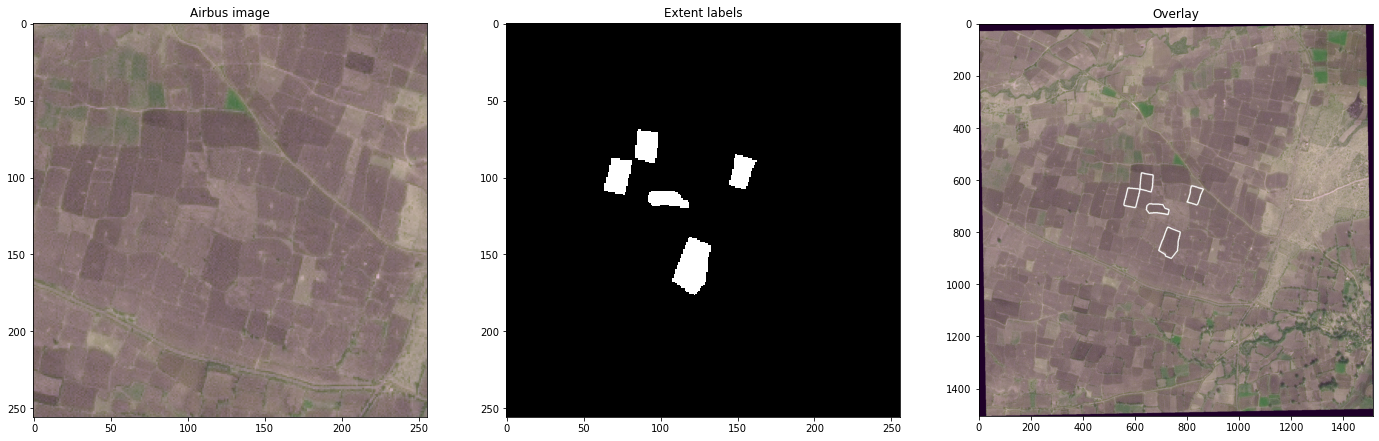

In [23]:
fig, ax = plt.subplots(1,3, figsize=(24,8))

image_id = '0001'

mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
ax[0].imshow(mask[center_x-128:center_x+128,center_y-128:center_y+128])
ax[0].set_title('Airbus image')

extent = imageio.imread('../data/general_blockchain/extent_labels/large/3x_downsample/{}.png'.format('airbus_geowiki_C' + image_id))
center_x, center_y = extent.shape[0] // 2, extent.shape[1] // 2
ax[1].imshow(extent[center_x-128:center_x+128,center_y-128:center_y+128], cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/general_blockchain/overlays/{}.jpeg'.format('airbus_geowiki_C' + image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

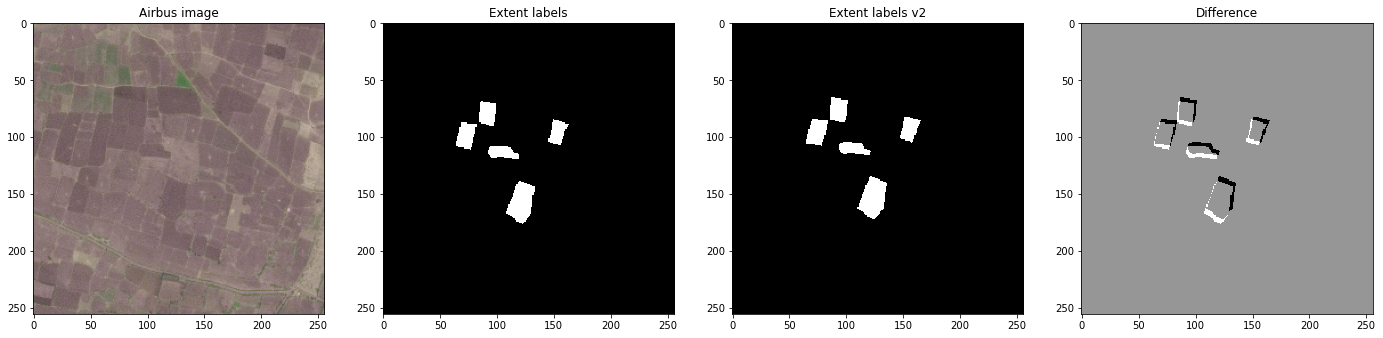

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(24,6))

image_id = '0001'

mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
ax[0].imshow(mask[center_x-128:center_x+128,center_y-128:center_y+128])
ax[0].set_title('Airbus image')

extent = imageio.imread(
    '../data/general_blockchain/extent_labels/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent.shape[0] // 2, extent.shape[1] // 2
ax[1].imshow(extent[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

extent2 = imageio.imread(
    '../data/general_blockchain/extent_labels/large/3x_downsample_v2/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent2.shape[0] // 2, extent2.shape[1] // 2
ax[2].imshow(extent2[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[2].set_title('Extent labels v2')

diff = np.array(extent, dtype=np.int8) - np.array(extent2, dtype=np.int8)
ax[3].imshow(diff[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=-1, vmax=1)
ax[3].set_title('Difference')

plt.show()

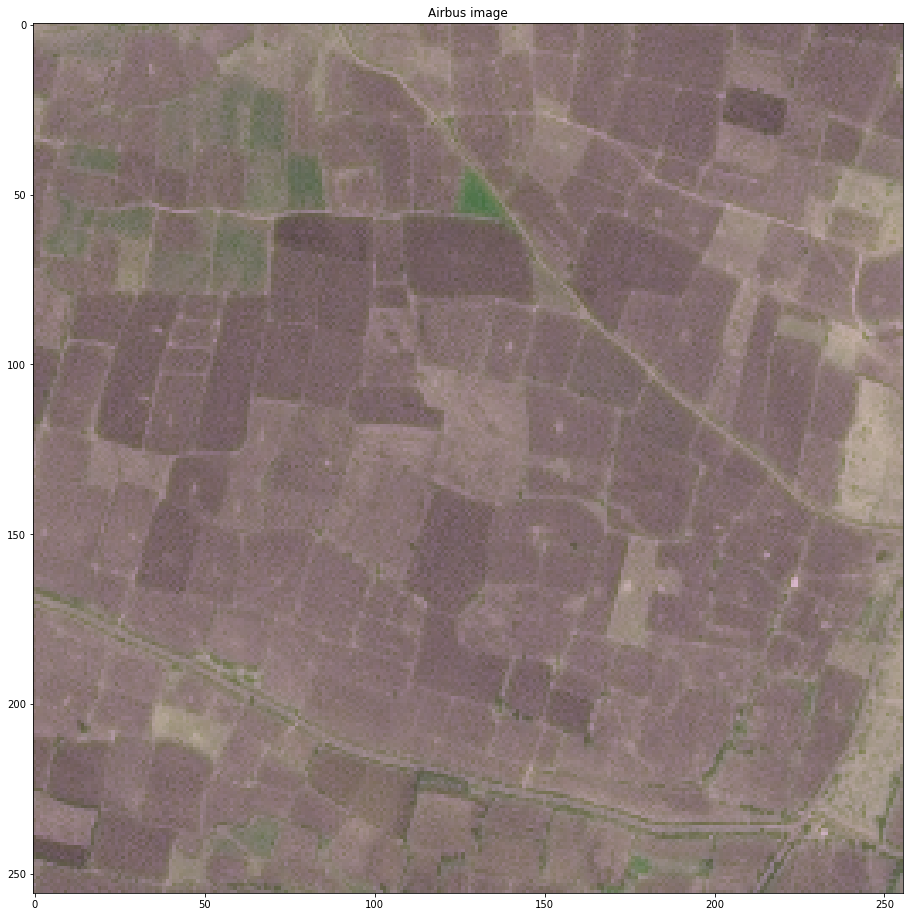

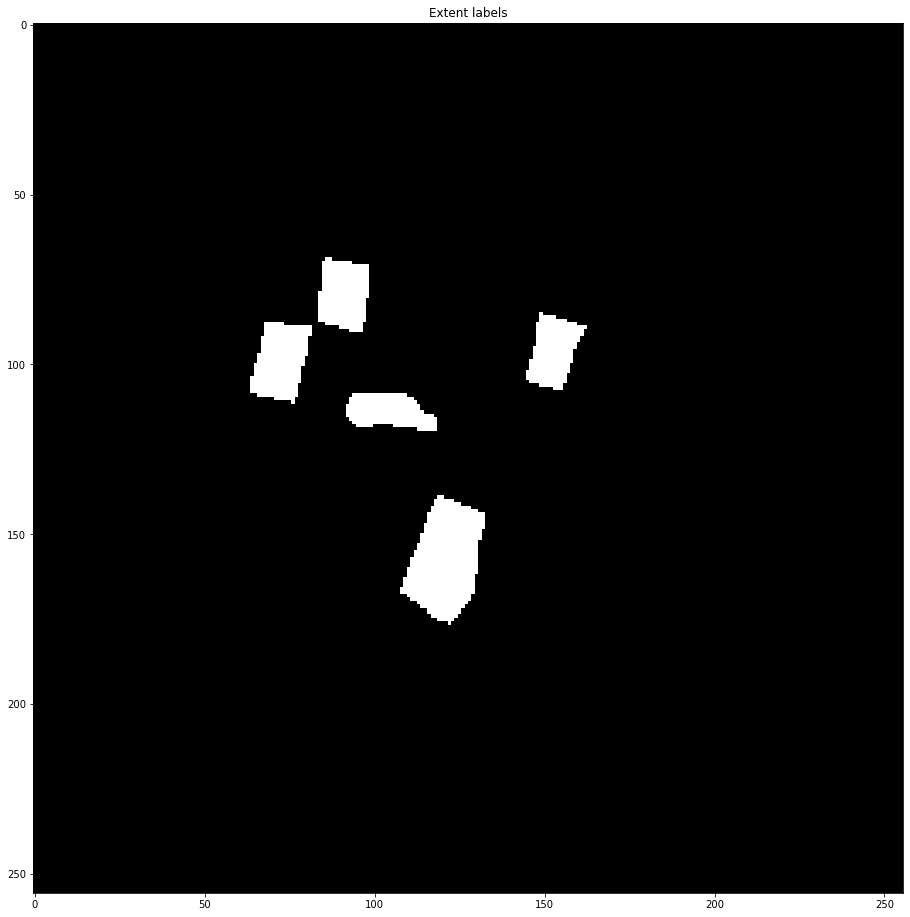

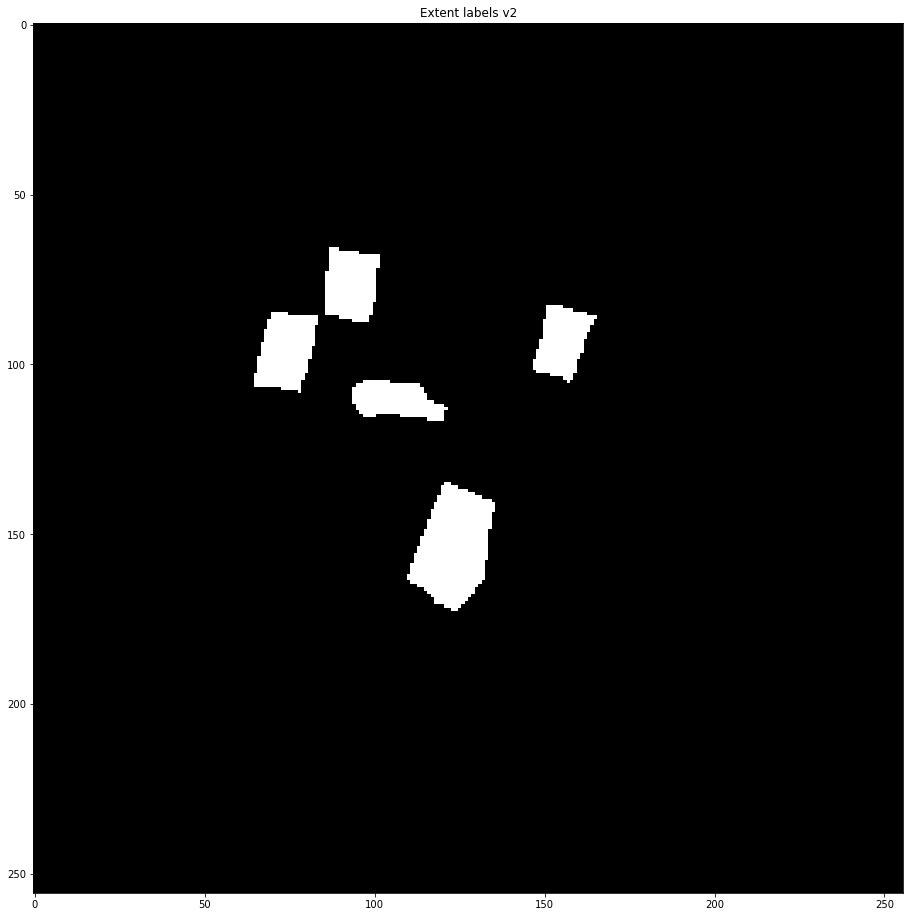

In [49]:
image_id = '0001'

fig, ax = plt.subplots(1, 1, figsize=(16,16))
mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
ax.imshow(mask[center_x-128:center_x+128,center_y-128:center_y+128])
ax.set_title('Airbus image')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16,16))
extent = imageio.imread(
    '../data/general_blockchain/extent_labels/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent.shape[0] // 2, extent.shape[1] // 2
ax.imshow(extent[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax.set_title('Extent labels')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16,16))
extent2 = imageio.imread(
    '../data/general_blockchain/extent_labels/large/3x_downsample_v2/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent2.shape[0] // 2, extent2.shape[1] // 2
ax.imshow(extent2[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax.set_title('Extent labels v2')
plt.show()

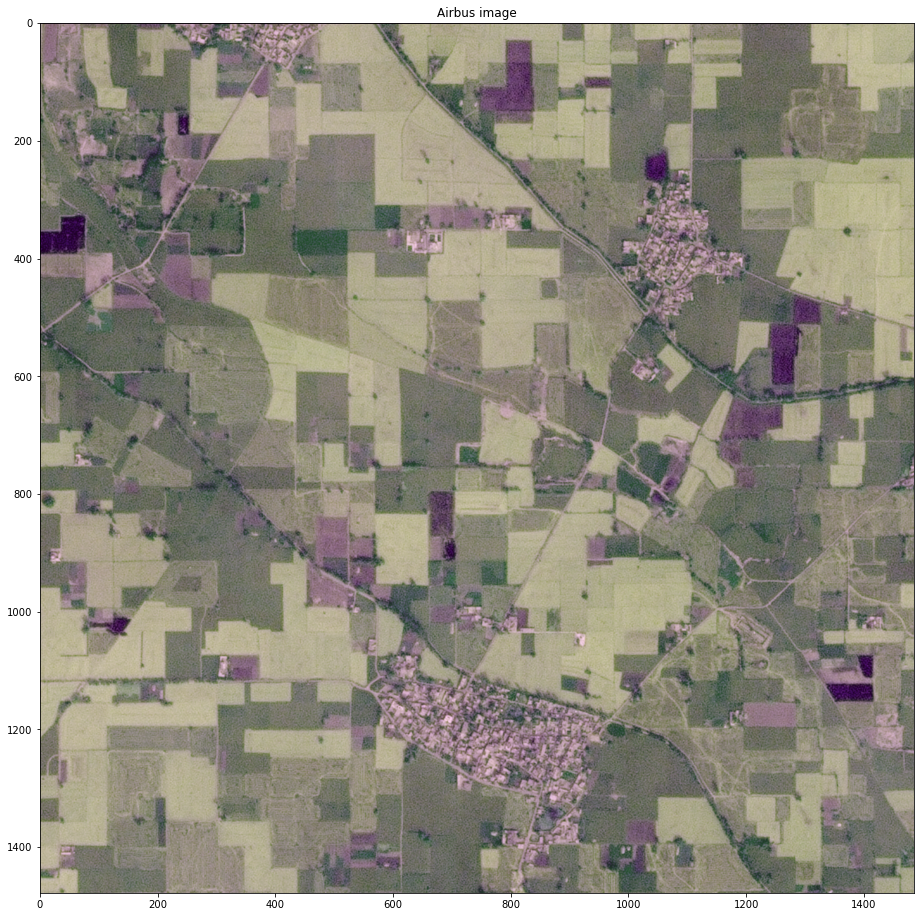

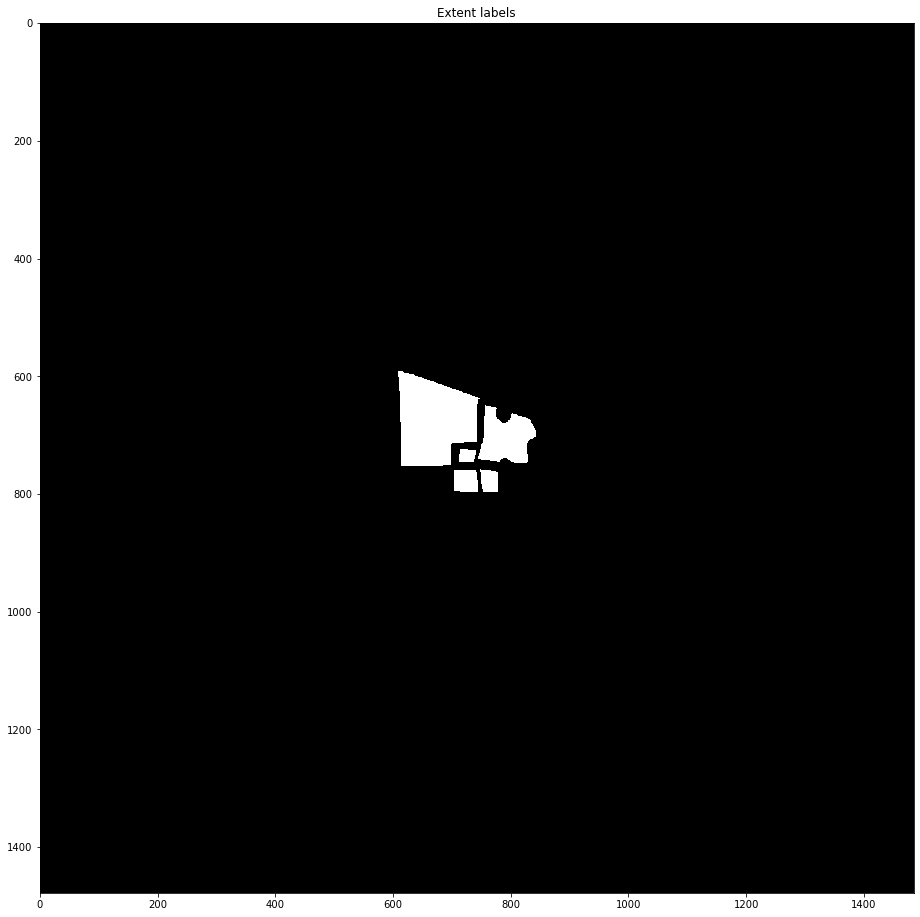

In [53]:
image_id = '0005'

fig, ax = plt.subplots(1, 1, figsize=(16,16))
mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/original/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
ax.imshow(mask)
ax.set_title('Airbus image')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16,16))
extent = imageio.imread(
    '../data/general_blockchain/extent_labels/large/original_thickness3/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent.shape[0] // 2, extent.shape[1] // 2
ax.imshow(extent, 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax.set_title('Extent labels')
plt.show()

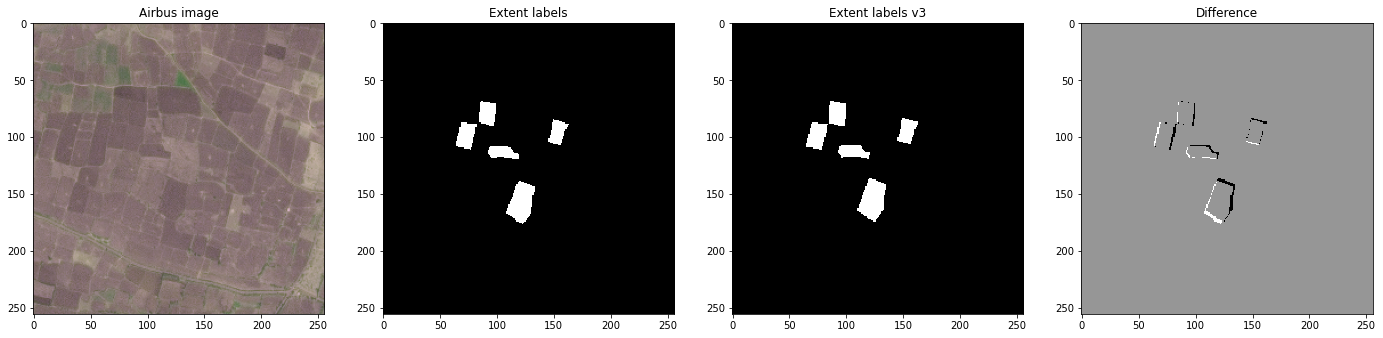

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(24,6))

image_id = '0001'

mask = imageio.imread(
    '../data/general_blockchain/airbus_false_color/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = mask.shape[0] // 2, mask.shape[1] // 2
ax[0].imshow(mask[center_x-128:center_x+128,center_y-128:center_y+128])
ax[0].set_title('Airbus image')

extent = imageio.imread(
    '../data/general_blockchain/extent_labels/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent.shape[0] // 2, extent.shape[1] // 2
ax[1].imshow(extent[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

extent2 = imageio.imread(
    '../data/general_blockchain/airbus_labels/large/3x_downsample/{}.png'.format(
    'airbus_geowiki_C' + image_id))
center_x, center_y = extent2.shape[0] // 2, extent2.shape[1] // 2
ax[2].imshow(extent2[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[2].set_title('Extent labels v3')

diff = np.array(extent, dtype=np.int8) - np.array(extent2, dtype=np.int8)
ax[3].imshow(diff[center_x-128:center_x+128,center_y-128:center_y+128], 
             cmap='Greys_r', interpolation='nearest', vmin=-1, vmax=1)
ax[3].set_title('Difference')

plt.show()

## Hand-labeled images

In [ ]:
create_empty_overlays(grid, orig_images_dir, suffix='_2019_10', n=200)

In [14]:
count_parcels = defaultdict(int)
num_fields_parsed = 0

# read multiple json files
print('Read json', json_file)

# open the saved json file for the found parcels in the images 
with open(json_file) as f:
    shp_dict = json.load(f)

# create dictionary of polygons in each image for fast indexing
parcels_dict = create_dict_parcels(shp_dict)

# find the polygons of each image and plot them
for index in range(len(grid.keys())):

    image_id = int(grid[index]['image_id'])
    polys = []
    if image_id in parcels_dict:
#         img = imageio.imread(os.path.join(orig_images_dir, 'airbus_geowiki_' + str(image_id) + '.png'))
        img = imageio.imread('../data/planet/india/geowiki/airbus_geowiki_960288.png')
        shape_size = (img.shape[0], img.shape[1])
        extent_path = os.path.join(base_dir, label_folder, str(image_id) + '.png')
        extent_label = np.zeros(shape_size)

        for sh_index, sh in enumerate(parcels_dict[image_id]):
            count_parcels[image_id] += 1 
            for coord_idx in range(len(sh['geometry']['coordinates'])):
                geom = np.array(sh['geometry']['coordinates'][coord_idx])
                try:
                    geom_fixed = scale_coords(shape_size, geom, grid, index)
                except:
                    print("Exception in image {}".format(image_id))
                    print(geom)
                pts = geom_fixed.astype(int)
                cv2.fillPoly(extent_label, [pts], color=(255,255,255))
                polys.append(pts)

        # Save the extent label
        cv2.polylines(extent_label, polys, True, color=(0,0,0), thickness=thickness)
        cv2.imwrite(extent_path, extent_label)

        # Saves the overlay file
#         overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
#         orig_image = cv2.imread(os.path.join(orig_images_dir, str(image_id) + year_month + '.tif'))
#         cv2.imwrite(overlay_path, orig_image)
#         orig_image = cv2.imread(overlay_path)
#         cv2.polylines(orig_image, polys, True, color=(255,255,255), thickness=thickness)
#         cv2.imwrite(overlay_path, orig_image)
#         print('saved image ', image_id)

    # save a small summary of number of parcels in each image
#     if start == 0:
#         open_mode = 'w'
#     else:
#         open_mode = 'a'
#     with open(os.path.join(base_dir, 'json_polys', 'parcel_in_image_count_1250px.csv'), open_mode) as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['image_id', 'count'])
#         for key, value in count_parcels.items():
#             writer.writerow([int(key), value])am

Read json ../data/planet/india/geowiki/json_polys/geowiki_labeled259.json


### Verify labels

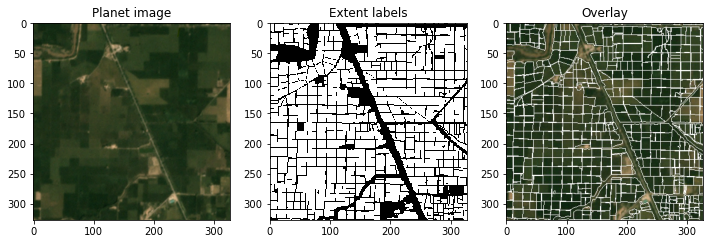

In [69]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '00126'

mask = imageio.imread('../data/planet/india/monthly_mosaics_renamed_clipped_merged/2019_10/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()

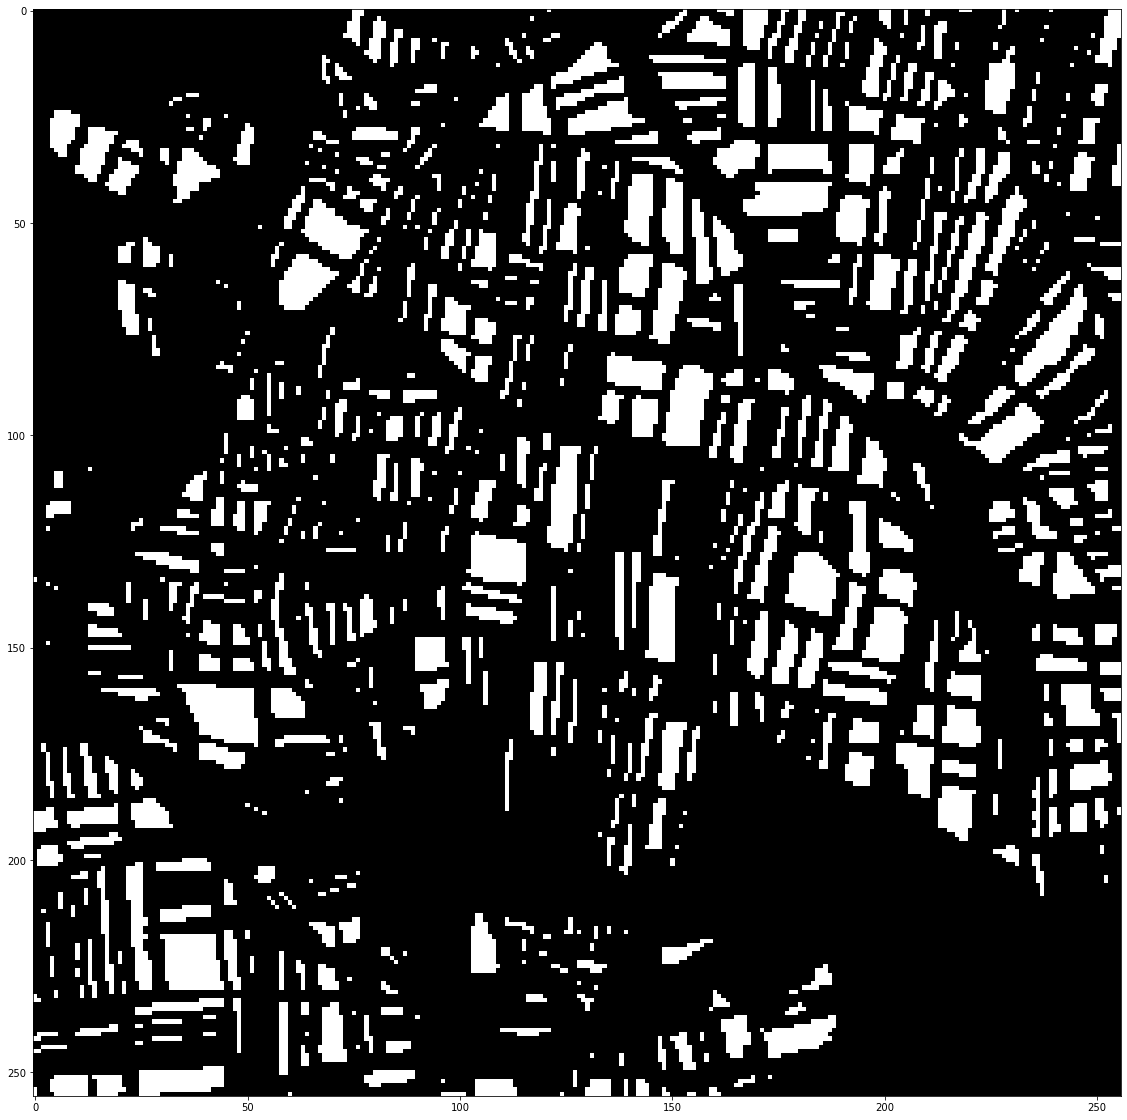

In [64]:
img_size_rows = 256
img_size_cols = 256
fig, ax = plt.subplots(1, 1, figsize=(20,20))
plt.imshow((cv2.resize(extent, (img_size_rows, img_size_cols), interpolation=cv2.INTER_NEAREST)),
           cmap='Greys_r')
plt.show()

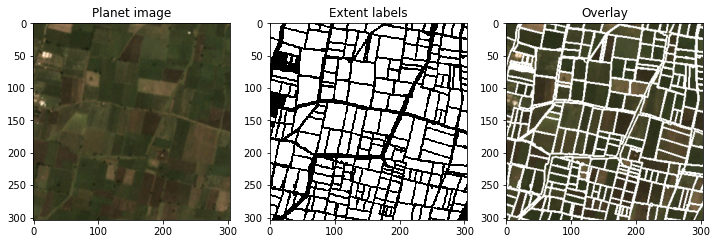

In [132]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '960228'

mask = imageio.imread('../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_10/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/geowiki/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/geowiki/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()